In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import multivariate_normal as mvn

## Linear path

In [10]:
N = 100
dt = 0.1
q1, q2 = 1, 1
s1, s2 = 0.5, 0.5


A = np.array([[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

Q = np.array([[(q1 * dt**3) / 3, 0, (q1 * dt**2) / 2, 0],
              [ 0, (q2 * dt**3) / 3, 0, (q2 * dt**2) / 2],
              [(q1 * dt**2) / 2, 0, q1 * dt, 0],
              [0, (q2 * dt**2) / 2, 0, q2 * dt]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

R = np.array([[s1, 0],
              [0, s2]])

In [11]:
# Generate data
x = np.array([0, 0, 1, 1])
true_trajectory = [x]
noisy_observations = [x[:2]]

for _ in range(N):
    x = A @ x + mvn([0, 0, 0, 0], Q)
    y = H @ x + mvn([0, 0], R)

    true_trajectory.append(x)
    noisy_observations.append(y)

true_trajectory = np.array(true_trajectory)
noisy_observations = np.array(noisy_observations)

In [12]:
# Kalman filter

P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_KF = [m]
Ps = [P]

for y in noisy_observations:
    m_pred = A @ m
    P_pred = A @ P @ A.T + Q
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    m = m_pred + K @ (y - H @ m_pred)
    P = P_pred - K @ S @ K.T
    
    Ps.append(P)
    estimated_trajectory_KF.append(m)

Ps = np.array(Ps)
estimated_trajectory_KF = np.array(estimated_trajectory_KF)

In [13]:
# RTS smoother
n, dim_x = estimated_trajectory_KF.shape

estimated_trajectory_RTS, P = estimated_trajectory_KF.copy(), Ps.copy()

for k in range(n-2,-1,-1):
    P_pred = A @ P[k] @ A.T + Q

    G = P[k] @ A.T @ np.linalg.inv(P_pred)
    estimated_trajectory_RTS[k] += G @ (estimated_trajectory_RTS[k+1] - A @ estimated_trajectory_RTS[k])
    #P[k] += (G @ (P[k+1] - P_pred)) @ G.T

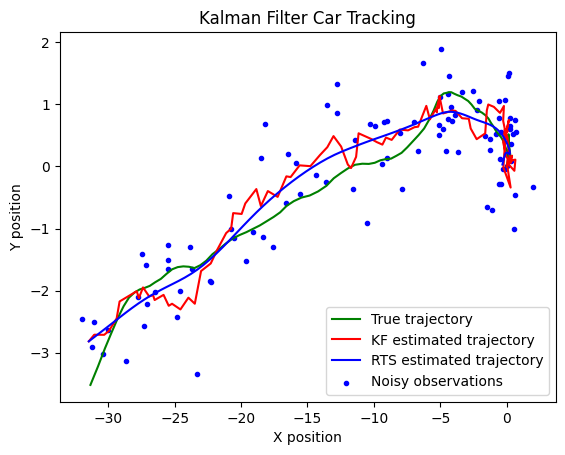

In [14]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.plot(estimated_trajectory_KF[:, 0], estimated_trajectory_KF[:, 1], 'r-', label='KF estimated trajectory')
plt.plot(estimated_trajectory_RTS[:, 0], estimated_trajectory_RTS[:, 1], 'b-', label='RTS estimated trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()